# Vignette for MultiMode 10X Genomics data

WNN analysis of 10x Multiome, RNA + ATAC

https://satijalab.org/seurat/articles/weighted_nearest_neighbor_analysis.html

Here we use our own human brain cell data from 10X genomics to differ from the vignette supplied
in order to run the vignette,
all packages installs are included for completeness but commented out for re-runs

Furthers details in 

https://github.com/neurogenomics/benchmark_epig_celltyping

in issues for setting up seurat

In [1]:
# optional if already installed
#setRepositories(ind=1:3) # needed to automatically install Bioconductor dependencies
#install.packages("Signac")

In [2]:
#optional if already installed
#if (!require("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install(version = "3.15")
#BiocManager::install(c('BSgenome.Hsapiens.UCSC.hg38', 'EnsDb.Hsapiens.v86'))

In [3]:
library(Seurat)
library(Signac)
library(EnsDb.Hsapiens.v86)
library(dplyr)
library(ggplot2)

Attaching SeuratObject

Attaching sp

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: ‘IRanges’


The following o

We’ll create a Seurat object based on the gene expression data, and then add in the ATAC-seq data as a second assay.

In [4]:
#include if needed
##install.packages("hdf5r")
library(hdf5r)


Attaching package: 'hdf5r'


The following object is masked from 'package:GenomicRanges':

    values


The following object is masked from 'package:S4Vectors':

    values




In [5]:
# the 10x hdf5 file contains both data types. 
inputdata.10x <- Read10X_h5("../data/10XGenomicsHumanBrainscMulti/human_brain_3k_filtered_feature_bc_matrix.h5")


Genome matrix has multiple modalities, returning a list of matrices for this genome



In [6]:
#may not be needed next time
#if (!require("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

#BiocManager::install("biovizBase")


Next Block split into sections due to longer run times

In [7]:
# extract RNA and ATAC data
rna_counts <- inputdata.10x$`Gene Expression`
atac_counts <- inputdata.10x$Peaks



In [8]:
# Create Seurat object
brainc <- CreateSeuratObject(counts = rna_counts)
brainc[["percent.mt"]] <- PercentageFeatureSet(brainc, pattern = "^MT-")



In [9]:
# Now add in the ATAC-seq data
# we'll only use peaks in standard chromosomes
grange.counts <- StringToGRanges(rownames(atac_counts), sep = c(":", "-"))
grange.use <- seqnames(grange.counts) %in% standardChromosomes(grange.counts)


In [10]:
atac_counts <- atac_counts[as.vector(grange.use), ]
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"
#
#Note this generates warning messages

Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objec

In [11]:
# read frag files from 10X genomics brain data
frag.file <- "../data/10XGenomicsHumanBrainscMulti/human_brain_3k_atac_fragments.tsv.gz"
chrom_assay <- CreateChromatinAssay(
   counts = atac_counts,
   sep = c(":", "-"),
   genome = 'hg38',
   fragments = frag.file,
   min.cells = 10,
   annotation = annotations
 )
brainc[["ATAC"]] <- chrom_assay

Computing hash




We perform basic QC based on the number of detected molecules for each modality as well as mitochondrial percentage. This step may be removed later if data is pre-processed for QC

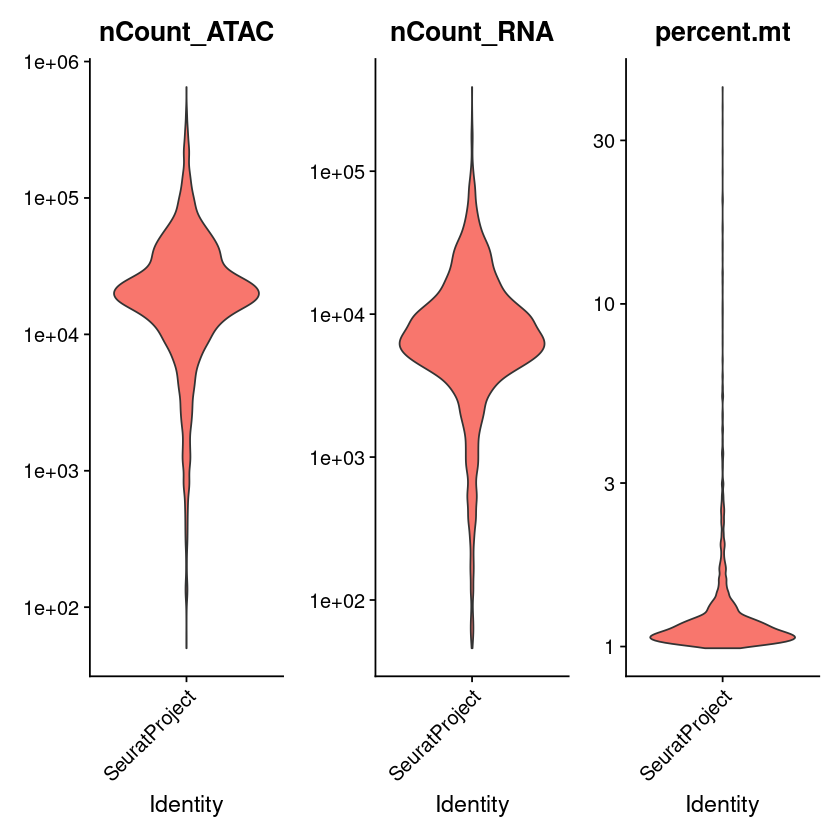

In [12]:
VlnPlot(brainc, features = c("nCount_ATAC", "nCount_RNA","percent.mt"), ncol = 3,
  log = TRUE, pt.size = 0) + NoLegend()

Will make some assumptions on using Seurate for QC. MT looks low

In [13]:
brainc <- subset(
  x = brainc,
  subset = nCount_ATAC < 8e4 &
    nCount_ATAC > 5e3 &
    nCount_RNA < 25000 &
    nCount_RNA > 1400 &
    percent.mt < 2
)

We next perform pre-processing and dimensional reduction on both assays independently, using standard approaches for RNA and ATAC-seq data.

In [14]:
# RNA analysis
DefaultAssay(brainc) <- "RNA"
brainc <- SCTransform(brainc, verbose = FALSE) %>% RunPCA() %>% RunUMAP(dims = 1:50, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_')

PC_ 1 
Positive:  CSMD1, NRG3, FGF14, OPCML, DLGAP1, NRXN1, FAM155A, RBFOX1, KCNIP4, ATRNL1 
	   FGF12, SNTG1, RIMS2, PLCB1, CCSER1, KCND2, TENM2, DSCAM, SYT1, CNTNAP5 
	   LRRTM4, SNHG14, MEG3, HS6ST3, GRIK2, STXBP5L, RGS7, ROBO2, GRM5, KAZN 
Negative:  CTNNA3, ST18, IL1RAPL1, PLP1, AC012494.1, SLC24A2, RNF220, LINC01608, PDE4B, MBP 
	   SLC7A14-AS1, PIP4K2A, SLC44A1, NKAIN2, MOBP, QKI, TMEM144, MAN2A1, AC008571.2, PLCL1 
	   DPYD, LINC01170, TF, TMTC2, LPAR1, TTLL7, FRMD4B, CRYAB, EDIL3, KCNH8 
PC_ 2 
Positive:  SLC1A2, GPC5, ADGRV1, GPM6A, OBI1-AS1, PITPNC1, CTNNA2, RYR3, LINC00299, SOX5 
	   SLC1A3, NKAIN3, LINC00499, ZNF98, HPSE2, AL137139.2, SLC4A4, ATP1A2, NHSL1, TPD52L1 
	   BMPR1B, TRPM3, DTNA, AC002429.2, NRXN1, ZNRF3, RANBP3L, CARMIL1, RORA, RFX4 
Negative:  CSMD1, RBFOX1, CNTNAP2, SYT1, FGF14, OPCML, CCSER1, RIMS2, MEG3, DLGAP1 
	   ROBO2, NRXN3, FGF12, ATRNL1, CNTNAP5, KCNIP4, SNHG14, CHRM3, KCNQ5, KAZN 
	   STXBP5L, FRMPD4, MYT1L, DLGAP2, DAB1, IL1RAPL1, SNTG1, GALNT17, G

In [15]:
# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(brainc) <- "ATAC"
brainc <- RunTFIDF(brainc)
brainc <- FindTopFeatures(brainc, min.cutoff = 'q0')
brainc <- RunSVD(brainc)
brainc <- RunUMAP(brainc, reduction = 'lsi', dims = 2:50, reduction.name = "umap.atac", reduction.key = "atacUMAP_")

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

14:14:14 UMAP embedding parameters a = 0.9922 b = 1.112

14:14:14 Read 2334 rows and found 49 numeric columns

14:14:14 Using Annoy for neighbor search, n_neighbors = 30

14:14:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:14:15 Writing NN index file to temp file /tmp/Rtmp6tEM5i/filee7fe6757a31bb

14:14:15 Searching Annoy index using 1 thread, search_k = 3000

14:14:15 Annoy recall = 100%

14:14:16 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:14:19 Initializing from normalized Laplacian + noise (using irlba)

14:14:19 Commencing optimization for 500 epochs, with 107424 positive edges

14:14:22 Optimization finished



We calculate a WNN graph, representing a weighted combination of RNA and ATAC-seq modalities. We use this graph for UMAP visualization and clustering

In [16]:
brainc <- FindMultiModalNeighbors(brainc, reduction.list = list("pca", "lsi"), dims.list = list(1:50, 2:50))
brainc <- RunUMAP(brainc, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
brainc <- FindClusters(brainc, graph.name = "wsnn", algorithm = 3, verbose = FALSE)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

14:14:39 UMAP embedding parameters a = 0.9922 b = 1.112

14:14:40 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

14:14:42 Initializing from normalized Laplacian + noise (using irlba)

14:14:42 Commencing optimization for 500 epochs, with 71756 positive edges

14:14:46 Optimization finished



** missing steps here relating to getting labels **

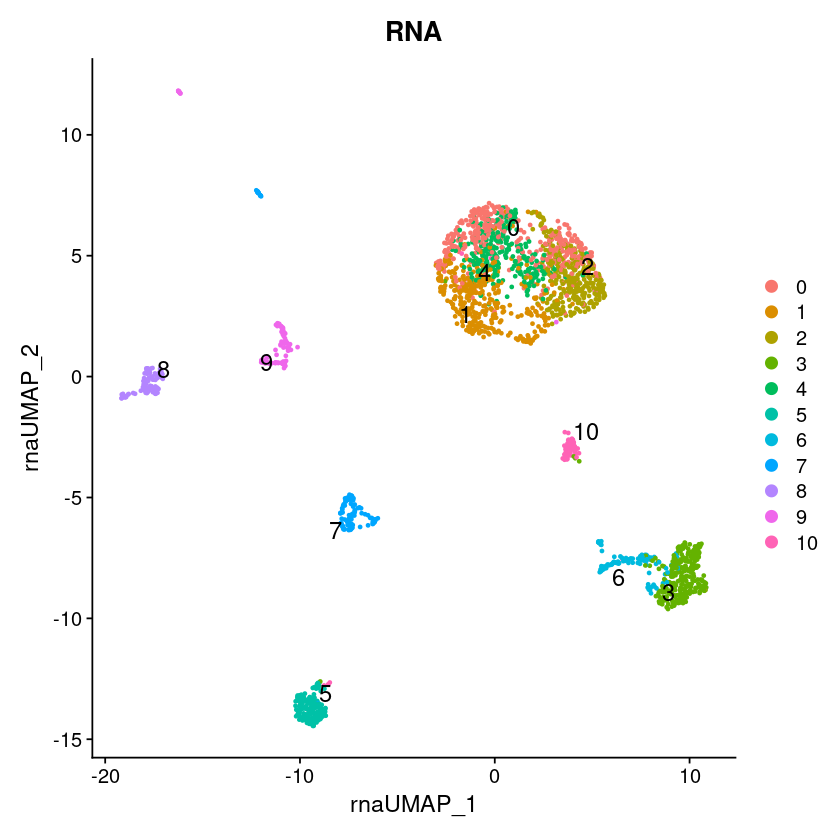

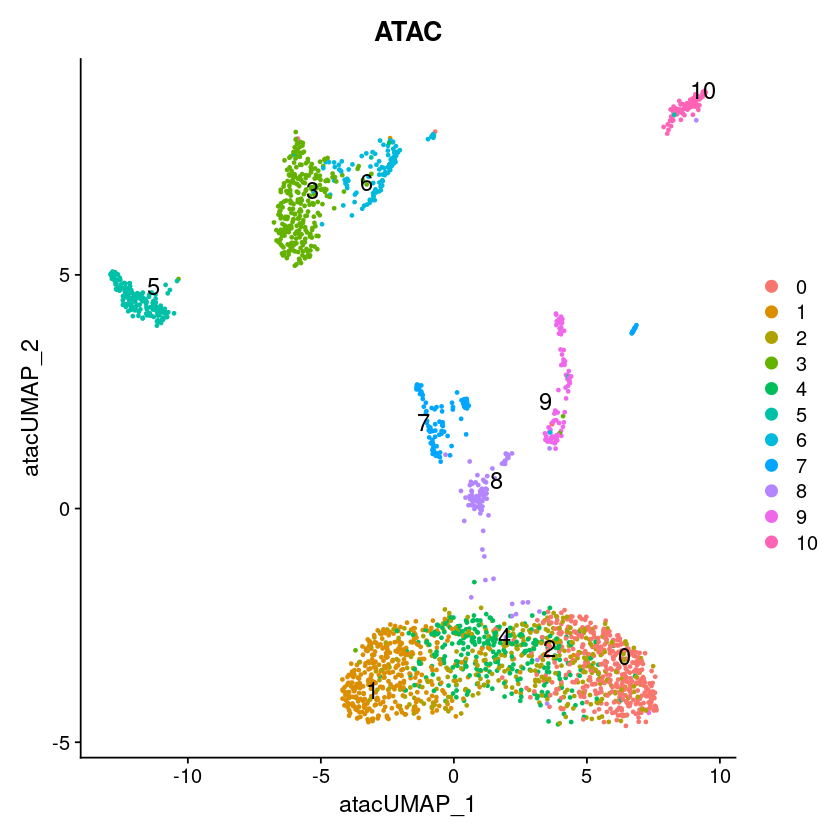

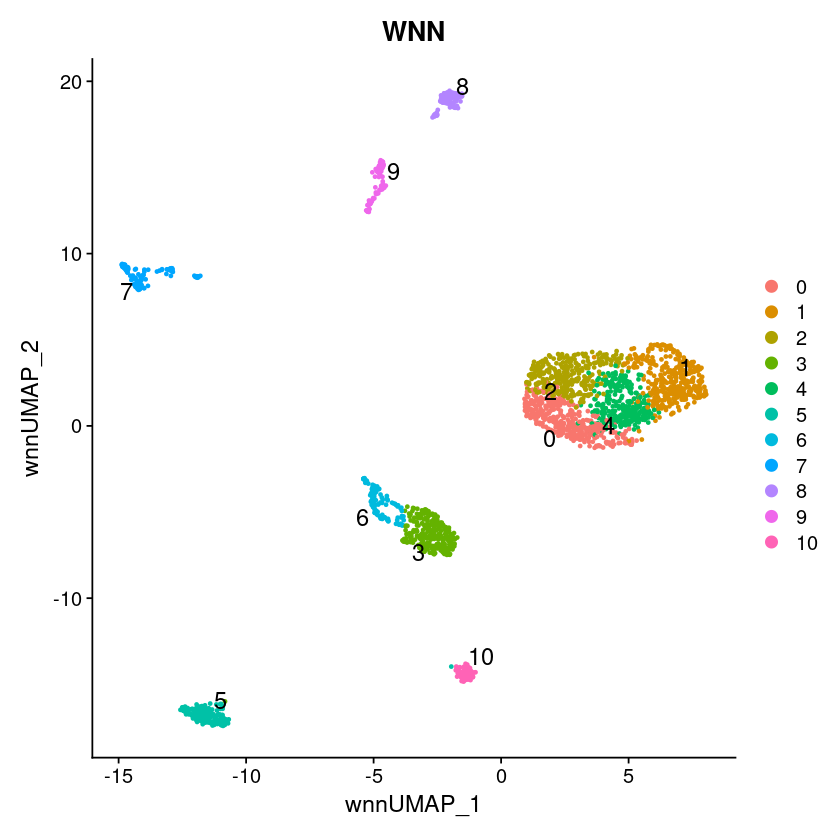

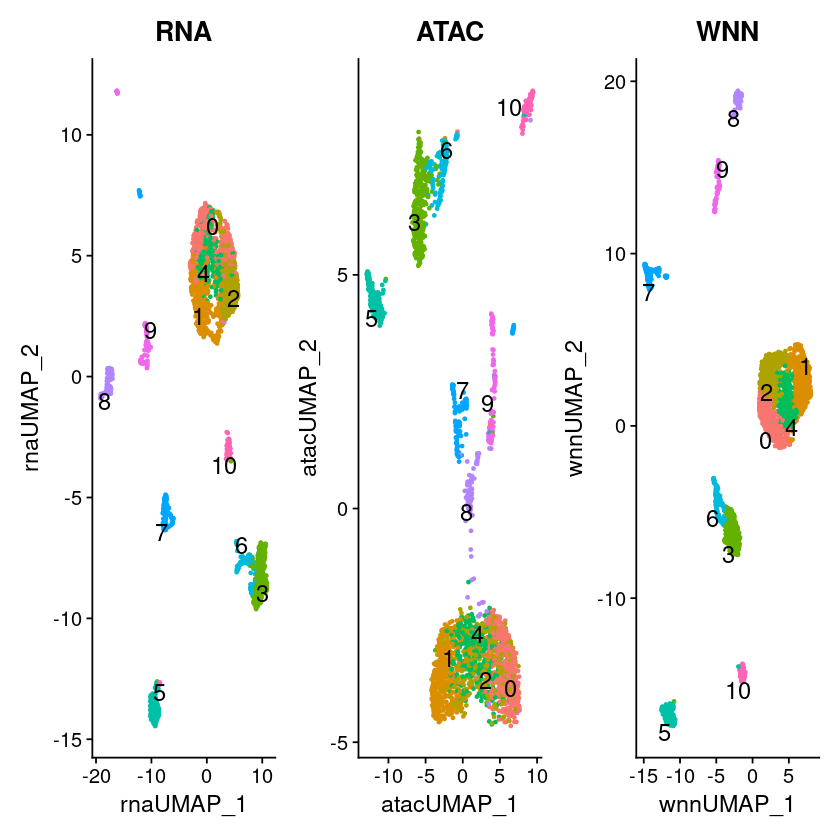

In [18]:
brainc$celltype <- Idents(brainc)
p1 <- DimPlot(brainc, reduction = "umap.rna", group.by = "celltype", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("RNA")
p1 
p2 <- DimPlot(brainc, reduction = "umap.atac", group.by = "celltype", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("ATAC")
p2
p3 <- DimPlot(brainc, reduction = "wnn.umap", group.by = "celltype", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("WNN")
p3 
p1 + p2 + p3 & NoLegend() & theme(plot.title = element_text(hjust = 0.5))